In [41]:
import torch
import torch.nn as nn
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import box_convert


from project_functions import *
from project_objects import *
from project_models import *
from project_constants import DEVICE as device
from project_constants import SEED

In [107]:
torch.manual_seed(SEED)
torch.set_default_dtype(torch.double)

## 2 Object Localization
#### First we load and inspect the localization datasets

In [108]:
loc_train = torch.load('data/localization_train.pt')
loc_val = torch.load('data/localization_val.pt')
loc_test = torch.load('data/localization_test.pt')

In [109]:
print(f'Train data size: {len(loc_train)}')
print(f'Val data size: {len(loc_val)}')
print(f'Test data size: {len(loc_test)}')

Train data size: 59400
Val data size: 6600
Test data size: 11000


In [110]:
first_img, first_label = loc_train[0]

print(f'Shape of first image: {first_img.shape}')
print(f'Type of first image: {type(first_img)}')

print(f'\nShape of first label: {first_label.shape}')
print(f'Type of first label: {type(first_label)})')
first_label

Shape of first image: torch.Size([1, 48, 60])
Type of first image: <class 'torch.Tensor'>

Shape of first label: torch.Size([6])
Type of first label: <class 'torch.Tensor'>)


tensor([1.0000, 0.6000, 0.2292, 0.3667, 0.4167, 4.0000], dtype=torch.float32)

In [111]:
# Assuming train_data, val_data, and test_data are defined elsewhere
count_instances(loc_train, 'Training Data')
count_instances(loc_val, 'Validation Data')
count_instances(loc_test, 'Test Data')


Class distribution in Training Data
0: 5345
1: 6075
2: 5365
3: 5522
4: 5243
5: 4889
6: 5310
7: 5644
8: 5249
9: 5358
99: 5400
Class distribution in Validation Data
0: 578
1: 667
2: 593
3: 609
4: 599
5: 532
6: 608
7: 621
8: 602
9: 591
99: 600
Class distribution in Test Data
0: 980
1: 1135
2: 1032
3: 1010
4: 982
5: 892
6: 958
7: 1028
8: 974
9: 1009
99: 1000


#### Plotting one image from each class

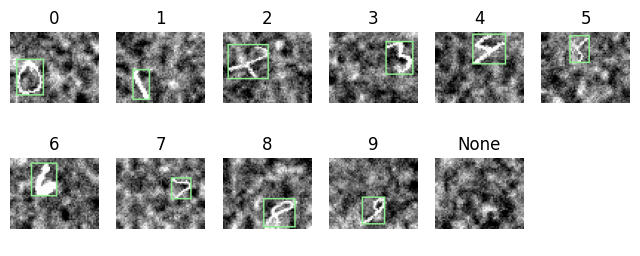

In [114]:
plot_images(loc_train)

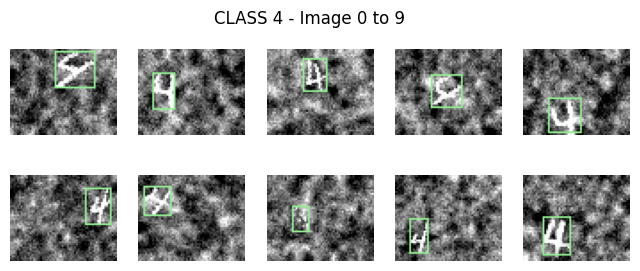

In [113]:
plot_class(loc_train, 4, 0)

#### Defining a normalizer and a preprocessor

In [ ]:
imgs = torch.stack([img for img, _ in loc_train])

# Define normalizer
normalizer_pipe = transforms.Normalize(
    imgs.mean(dim=(0, 2, 3)), 
    imgs.std(dim=(0, 2, 3))
    )

# Define preprocessor including the normalizer
preprocessor = transforms.Compose([
            normalizer_pipe
        ])

In [ ]:
loc_train_norm = [(preprocessor(img), label) for img, label in loc_train]
loc_val_norm = [(preprocessor(img), label) for img, label in loc_val]
loc_test_norm = [(preprocessor(img), label) for img, label in loc_test]

In [ ]:
train_loader = torch.utils.data.DataLoader(loc_train_norm, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(loc_val_norm, batch_size=64, shuffle=False)

loss_fn = LocalizationLoss()

#### Defining models

In [ ]:
model_name = 'model5test2'

torch.manual_seed(SEED)
model = MyCNN5((48,60,1))
model.to(device=device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)

loss_train, loss_val, train_perform, val_perform, losses_separated = train(
    n_epochs=50,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader=val_loader
)

plot_loss(loss_train, loss_val, model_name, save_model=True)
plot_lists(losses_separated, ['detection loss', 'localization loss', 'classification loss'], model_name, save_model=True)
y_true, y_pred = predict(model, val_loader)
plot_predictions(loc_val, y_true, y_pred, label=4, start_idx=0, fig_name=model_name, save_model=True)

#### Selecting the best model

In [ ]:
best_model, best_performance = model_selector([model], [val_perform])

# Print additional details of the best model
print("Best Model Details\n--------------------------------------------------------------")
print(f"Network architecture/ layout: {best_model}\n")
#print(f"Optimizer Parameters: {best_data.optimizer")
print(f"Validation Performance: {best_performance}")
#print(f"Validation Accuracy {round(best_data['model_man_val_accuracy'], 2)}")

#### Evaluating the best model on unseen data TBD

In [ ]:
test_loader = torch.utils.data.DataLoader(loc_test_norm, batch_size=64, shuffle=False)

test_acc, test_iou, test_performance = compute_performance(best_model, test_loader)
print(10*'-'+'Test Performance' + 10*'-')
print(f"Test Accuracy: {test_acc}\nTest IOU: {test_iou}\nOverall Performance: {test_performance}")

In [ ]:
y_true, y_pred = predict(best_model, test_loader)

In [ ]:
plot_predictions(loc_test, y_true, y_pred, label=6, start_idx=0)

# 3 Object Detection

#### Loading the data and inspecting the data

In [116]:
train_labels = torch.load('data/list_y_true_train.pt')
val_labels = torch.load('data/list_y_true_val.pt')
test_labels = torch.load('data/list_y_true_test.pt')

In [117]:
print(f'Train label size: {len(train_labels)}')
print(f'Val label size: {len(val_labels)}')
print(f'Test label size: {len(test_labels)}')

Train label size: 26874
Val label size: 2967
Test label size: 4981


In [118]:
det_train = torch.load('data/detection_train.pt')
det_val = torch.load('data/detection_val.pt')
det_test = torch.load('data/detection_test.pt')

In [119]:
print(f'Train label size: {len(det_train)}')
print(f'Val label size: {len(det_val)}')
print(f'Test label size: {len(det_test)}')

Train label size: 26874
Val label size: 2967
Test label size: 4981


In [ ]:
def local_to_global(bbox, W_out, H_out, W_img, H_img):
    """Does things """


    return bbox

    


def global_to_local(global_coordinates, H_out, W_out):
    """Does things """
    w_boundaries = [i / W_out for i in range(0, W_out)]
    w_boundaries = [(idx, boundary) for idx, boundary in enumerate(w_boundaries)]
    w_boundaries.reverse()

    h_boundaries = [i / H_out for i in range(0, H_out)]
    #h_boundaries = [(idx, boundary) for idx, boundary in enumerate(h_boundaries)]
    h_boundaries.reverse()

    print(w_boundaries, h_boundaries)

    x_global, y_global = global_coordinates[0].item(), global_coordinates[1].item()
    x_boundary, x_cell = next(((boundary, idx) for idx, boundary in w_boundaries if boundary < y_global))
    y_boundary, y_cell = next(((boundary, idx) for idx, boundary in enumerate(h_boundaries) if boundary < x_global))

    x_local = abs((x_global - x_boundary) * W_out)
    y_local = abs((y_global - y_boundary) * H_out)

    return x_local, y_local, (x_cell, y_cell)
    
global_cord = [0.5, 0.6771, 0.1667, 0.4792]
#print(global_to_local(global_cord, 2, 3))

In [ ]:
def plot_detection_data(data, H_out, W_out):
    """W_out H_out should be shape of grid"""
    _, axes = plt.subplots(nrows=2, ncols=5, figsize=(8,3))

    for i, ax in enumerate(axes.flat): 
        
        img, label = data[i]
        img_height, img_width = img.shape[-2], img.shape[-1]
        img = (img * 255).byte()

        for row_idx, row in enumerate(label):
            for col_idx, gridcell in enumerate(row):
                if int(gridcell[0]) == 1:
                    bbox = gridcell[1:5].clone()
                    
                    cell_width = img_width / W_out
                    cell_height = img_height / H_out
                    x_boundary = col_idx * cell_width
                    y_boundary = row_idx * cell_height
                    
                    bbox[0] = ((bbox[0] / x_boundary) * W_out) * img_width
                    bbox[1] = ((bbox[1] / y_boundary) * H_out) * img_height
                    bbox[2] = bbox[2] * img_width
                    bbox[3] = bbox[3] * img_height

                    bbox = bbox.type(torch.uint8)

                    converted_bbox = box_convert(bbox, in_fmt='cxcywh', out_fmt='xyxy')

                    img = draw_bounding_boxes(img, converted_bbox.unsqueeze(0), colors='lightgreen')

        img  = img.numpy().transpose((1, 2, 0))
        ax.imshow(img, cmap='gray')
        ax.set_title(i)
        ax.axis('off')

plot_detection_data(data=det_train, H_out=2, W_out=3)

In [ ]:
def prepare_labels(y_true, H_out, W_out):
    """
    1. Create empty tensor in right format
    2. Change to local coordinates
    3. Which grid cell does each object belong to?
    4. Place in correct cell
    """
    label_tensor = torch.zeros(2, 3, 6)
    for label in y_true:
        x_local, y_local, grid_pos = global_to_local(label[1:5], H_out, W_out)
        print(grid_pos)
        label[1] = x_local
        label[2] = y_local
        label[3] *= W_out
        label[4] *= H_out
        label_tensor[grid_pos[1], grid_pos[0]] = label
    return label_tensor

In [203]:
train_labels = torch.load('data/list_y_true_train.pt')
val_labels = torch.load('data/list_y_true_val.pt')
test_labels = torch.load('data/list_y_true_test.pt')

det_train = torch.load('data/detection_train.pt')
det_val = torch.load('data/detection_val.pt')
det_test = torch.load('data/detection_test.pt')

def global_to_local(labels_list:list, grid_dimension:tuple):
    '''
    Transfers one list of tensors to local values
    '''

    x = grid_dimension[1]
    y = grid_dimension[0]
    vector_length = grid_dimension[2]

    returned_tensor = torch.zeros(y,x,vector_length)

    x_grid_cells = [(i+1)/x for i in range(x)]
    y_grid_cells = [(i+1)/y for i in range(y)]

    for label in labels_list:

        for i in range(x):

            if label[1] < x_grid_cells[i]:
                x_cell = i
                if i != 0:
                    label[1] -= x_grid_cells[i-1]
                break

        for i in range(y):

            if label[2] < y_grid_cells[i]:
                y_cell = i
                if i != 0:
                    label[2] -= y_grid_cells[i-1]
                break

        label[1] *= x
        label[3] *= x
        label[2] *= y
        label[4] *= y

        returned_tensor[y_cell][x_cell] = label

    return returned_tensor

def prepare_labels(label_dataset:list, grid_dimension:tuple):
    '''
    Iterates through each listed tensor, transforms from global to local coordinates, and stacks them into a new tensor.
    '''

    new_tensor = torch.stack([global_to_local(label, grid_dimension) for label in label_dataset])

    return new_tensor

def merge_datasets(d1, d2):
    '''
    Combines the new labels with the image data.
    '''
    from torch.utils.data import TensorDataset

    return TensorDataset(d2[:][0],d1[:])

def local_to_global(labels_tensor:torch.Tensor, grid_dimension:tuple):
    '''
    Returns to original format.
    '''

    list_of_tensors = []


    for i in range(len(labels_tensor)):
        inner =[]
        x = labels_tensor[i,:,:]
        not_all_zero = x.any(dim=-1)
        for each in x[not_all_zero]:
            inner.append(each)
        if inner != []:
            list_of_tensors.append(inner)

    return list_of_tensors


new_dataset = prepare_labels(train_labels, (2,3,6))

new = merge_datasets(new_dataset, det_train)
print(new[0])
print(det_train[0])


    
new = local_to_global(new_dataset,(2,3,6))

print(new[0])
print(train_labels[0])

(tensor([[[0.3076, 0.2098, 0.5142,  ..., 0.0969, 0.1777, 0.1449],
         [0.3975, 0.2270, 0.2177,  ..., 0.0000, 0.1338, 0.0000],
         [0.2963, 0.3896, 0.2755,  ..., 0.1037, 0.0000, 0.0000],
         ...,
         [0.3741, 0.3321, 0.4604,  ..., 0.1887, 0.0000, 0.0000],
         [0.2101, 0.3359, 0.3832,  ..., 0.2110, 0.1496, 0.0000],
         [0.3251, 0.2166, 0.4339,  ..., 0.0809, 0.0000, 0.1337]]],
       dtype=torch.float32), tensor([[[1.0000, 0.7750, 0.8125, 0.3500, 0.7917, 1.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.9500, 0.3333, 0.7000, 0.6667, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]]))
(tensor([[[0.3076, 0.2098, 0.5142,  ..., 0.0969, 0.1777, 0.1449],
         [0.3975, 0.2270, 0.2177,  ..., 0.0000, 0.1338, 0.0000],
         [0.2963, 0.3896, 0.2755,  ..., 0.1037, 0.0000, 0.0000],
         

In [ ]:
prepare_labels(label, 2, 3)

#### Defining the loss function

In [ ]:
class DetectionLoss(nn.Module):
    """Custom loss function"""
    def __init__(self):
        super().__init__()
        self.L_a = nn.BCEWithLogitsLoss()  # detection loss
        self.L_b = nn.MSELoss()  # localization loss
        self.L_c = nn.CrossEntropyLoss()  # classification loss

    def forward(self, y_pred, y_true):

        det_pred = y_pred[:, 0]
        bbox_pred = y_pred[:, 1:5]
        class_pred = y_pred[:, 5:]

        det_true = y_true[:, 0]
        bbox_true = y_true[:, 1:5]
        class_true = y_true[:, -1].long()

        L_a = self.L_a(det_pred, det_true)

        object_detected = det_true == 1

        L_b = self.L_b(bbox_pred[object_detected], bbox_true[object_detected])
        L_c = self.L_c(class_pred[object_detected], class_true[object_detected])

        return L_a + L_b + L_c